In [1]:
import matplotlib.pyplot as plt
import torch
from torchvision.transforms import Normalize
import os
import sys
import torch
import torch.nn as nn

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

import torch
import torch.nn as nn

class Discriminator(nn.Module):
    """
    Класс Discriminator представляет собой сверточную нейронную сеть, используемую для различения изображений.
    
    Аргументы:
    in_channels (int): Количество входных каналов. По умолчанию 4 (1 канал для источника и 3 канала для цели).
    
    Методы:
    __init__(self, in_channels=4): Инициализирует слои дискриминатора.
    forward(self, src, target): Выполняет прямое распространение через сеть. Объединяет входные изображения (src и target) по каналу и пропускает их через модель.
    
    Пример использования:
    discriminator = Discriminator()
    output = discriminator(src_image, target_image)
    """
    def __init__(self, in_channels=4):  # 2 channel source + 3 channels target
        super(Discriminator, self).__init__()
        def discriminator_block(in_channels, out_channels, stride):
            layers = [
                nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=stride, padding=1),
                nn.BatchNorm2d(out_channels),  # No BN in first layer
                nn.LeakyReLU(0.2, inplace=True)
            ]
            return layers

        self.model = nn.Sequential(
            # C64: 4x4 kernel, stride 2, padding 1
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            # C128: 4x4 kernel, stride 2, padding 1
            *discriminator_block(64, 128, stride=2),

            # C256: 4x4 kernel, stride 2, padding 1
            *discriminator_block(128, 256, stride=2),

            # C512: 4x4 kernel, stride 1, padding 1
            *discriminator_block(256, 512, stride=1),

            # C1: 4x4 kernel, stride 1, padding 1
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1),

            # Sigmoid activation
            nn.Sigmoid()
        )


    def forward(self, src, target):
        x = torch.cat((src, target), dim=1)
        return self.model(x)

if __name__ == '__main__':
    D = Discriminator()
    x = torch.randn(1, 1, 256, 256)
    target = torch.randn(1, 3, 256, 256)
    print(f'{x.shape} + {target.shape} -> {D(x, target).shape}')  # torch.Size([1, 1, 30, 30])


class UNetGenerator(nn.Module):
    def __init__(self, input_channels=1, output_channels=3):
        super(UNetGenerator, self).__init__()
        
        def encoder_block(in_channels, out_channels, use_bn=True):
            layers = [
                nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
                nn.LeakyReLU(0.2, inplace=True)
            ]
            if use_bn:
                layers.append(nn.BatchNorm2d(out_channels))
            return nn.Sequential(*layers)

        def decoder_block(in_channels, out_channels, dropout=0):
            layers = [
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(out_channels)
            ]
            if dropout != 0:
                layers.append(nn.Dropout(dropout))
            return nn.Sequential(*layers)

        def bottleneck_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
                nn.ReLU(inplace=True),
            )

        # Encoder
        self.enc1 = encoder_block(input_channels, 64, use_bn=False)
        self.enc2 = encoder_block(64, 128)
        self.enc3 = encoder_block(128, 256)
        self.enc4 = encoder_block(256, 512)
        self.enc5 = encoder_block(512, 512)
        self.enc6 = encoder_block(512, 512)
        self.enc7 = encoder_block(512, 512)

        self.bottleneck = bottleneck_block(512, 512)

        # Decoder
        self.dec1 = decoder_block(512, 512, dropout=0.5)
        self.dec2 = decoder_block(1024, 512, dropout=0.5)
        self.dec3 = decoder_block(1024, 512, dropout=0.5)
        self.dec4 = decoder_block(1024, 512)
        self.dec5 = decoder_block(1024, 256)
        self.dec6 = decoder_block(512, 128)
        self.dec7 = decoder_block(256, 64)
        self.final = nn.ConvTranspose2d(128, output_channels, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)
        e5 = self.enc5(e4)
        e6 = self.enc6(e5)
        e7 = self.enc7(e6)

        b = self.bottleneck(e7)

        # Decoder + Skip connections
        d1 = self.dec1(b)
        d2 = self.dec2(torch.cat([d1, e7], dim=1))
        d3 = self.dec3(torch.cat([d2, e6], dim=1))
        d4 = self.dec4(torch.cat([d3, e5], dim=1))
        d5 = self.dec5(torch.cat([d4, e4], dim=1))
        d6 = self.dec6(torch.cat([d5, e3], dim=1))
        d7 = self.dec7(torch.cat([d6, e2], dim=1))
        return torch.tanh(self.final(torch.cat([d7, e1], dim=1)))

if __name__ == '__main__':
    G = UNetGenerator()
    x = torch.randn(1, 1, 256, 256)
    print(f'{x.shape} -> {G(x).shape}')  # torch.Size([1, 3, 256, 256])


class Pix2PixGAN:
    def __init__(self, device):
        self.device = device
        self.generator = UNetGenerator().to(self.device)
        self.discriminator = Discriminator().to(self.device)

        self.optimizer_G = torch.optim.AdamW(self.generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        self.optimizer_D = torch.optim.AdamW(self.discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

        self.criterion_GAN = nn.BCEWithLogitsLoss()
        self.criterion_L1 = nn.L1Loss()

    def train_step(self, real_A, real_B):
        real_A, real_B = real_A.to(self.device), real_B.to(self.device)

        # Train Discriminator
        self.optimizer_D.zero_grad()
        fake_B = self.generator(real_A)

        # Получаем выходные данные дискриминатора
        output_real = self.discriminator(real_A, real_B)
        output_fake = self.discriminator(real_A, fake_B.detach())

        # Создаем целевые метки того же размера, что и выходные данные дискриминатора
        target_real = torch.ones_like(output_real)
        target_fake = torch.zeros_like(output_fake)

        # Вычисляем потери
        loss_D_real = self.criterion_GAN(output_real, target_real)
        loss_D_fake = self.criterion_GAN(output_fake, target_fake)
        loss_D = (loss_D_real + loss_D_fake) / 2
        loss_D.backward()
        self.optimizer_D.step()

        # Train Generator
        self.optimizer_G.zero_grad()
        loss_G_GAN = self.criterion_GAN(self.discriminator(real_A, fake_B), torch.ones_like(output_real))
        loss_G_L1 = self.criterion_L1(fake_B, real_B) * 100
        loss_G = loss_G_GAN + loss_G_L1
        loss_G.backward()
        self.optimizer_G.step()

        return loss_D.item(), loss_G.item()



torch.Size([1, 1, 256, 256]) + torch.Size([1, 3, 256, 256]) -> torch.Size([1, 1, 30, 30])
torch.Size([1, 1, 256, 256]) -> torch.Size([1, 3, 256, 256])


Using cpu
Чекпоинт успешно загружен: c:\Users\tiruu\OneDrive\Desktop\sar2opt\checkpoints/checkpoint_epoch_250.pth
Дата сохранения: 2024-12-21T19:40:11, эпоха 250


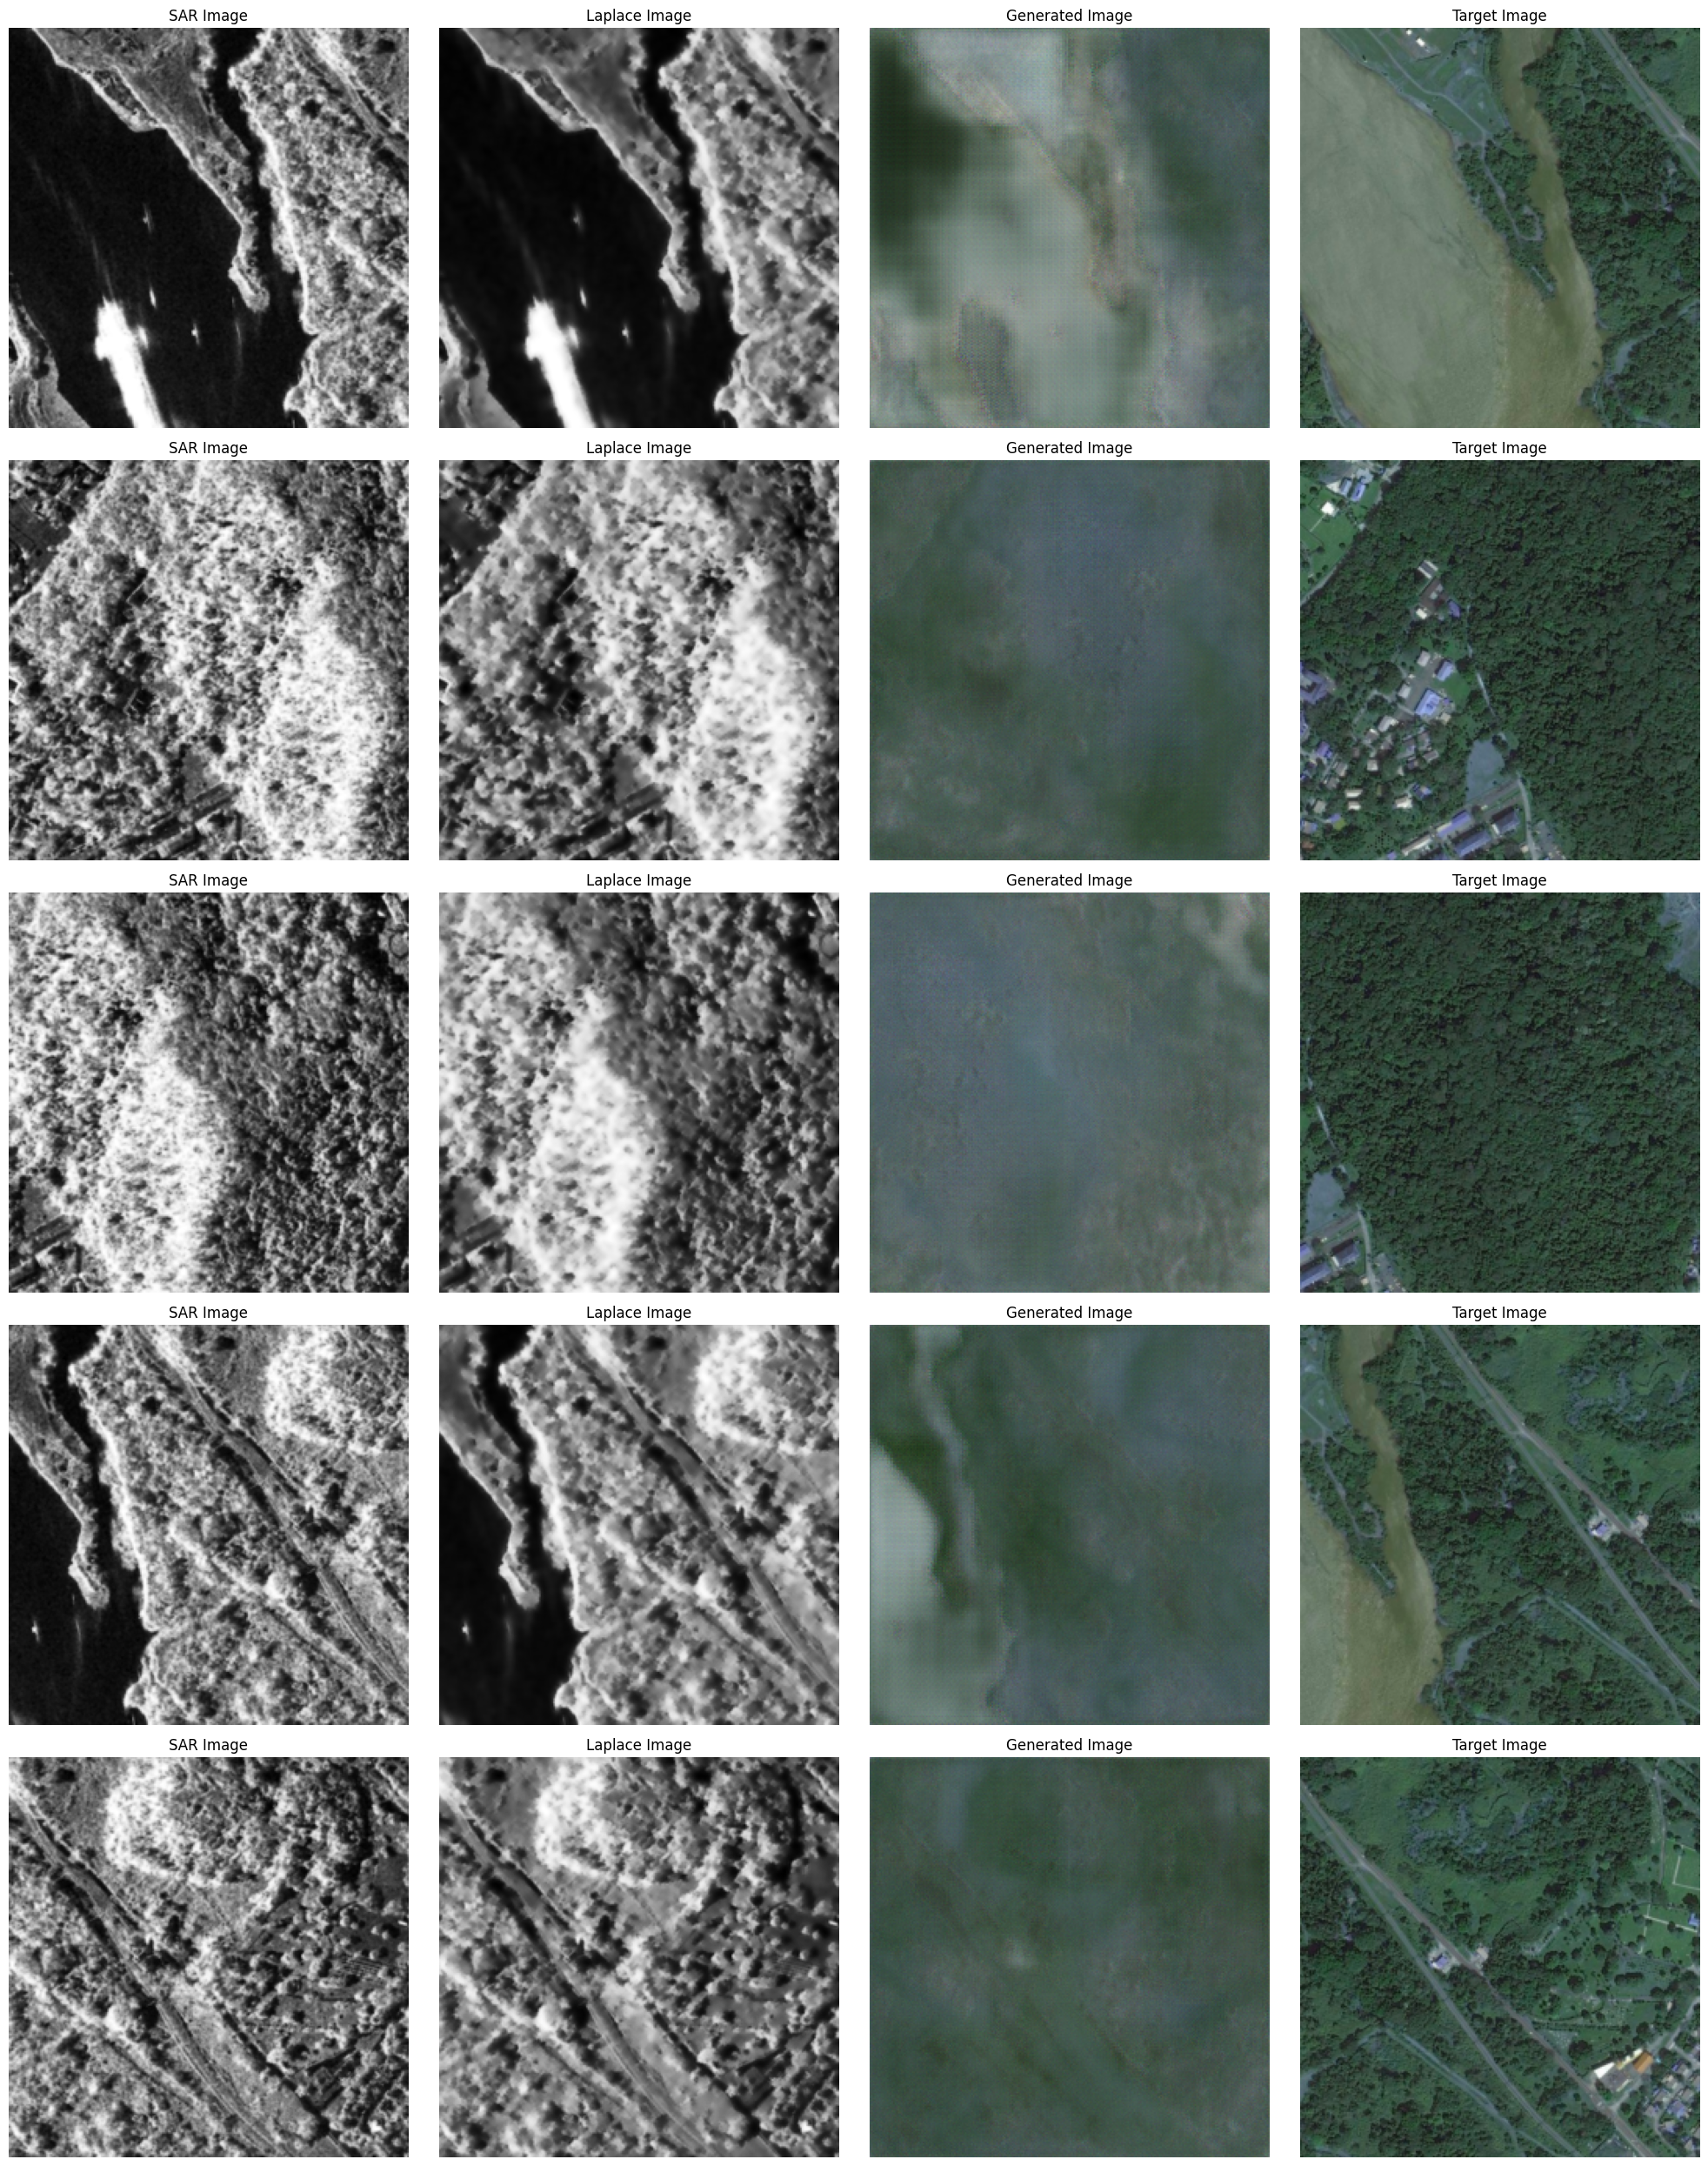

In [8]:
from utils.helpers import *
from utils.lossTracker import save_losses, load_losses
from utils.checkpointLogic import save_checkpoint, load_checkpoint
from tqdm.notebook import tqdm
from scipy.ndimage import uniform_filter

device = torch.device("cpu") # torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu")
print(f'Using {device}')
torch.cuda.empty_cache() if torch.cuda.is_available() else torch.mps.empty_cache() if torch.mps.is_available() else None
model = Pix2PixGAN(device)

start_epoch, loss_G, loss_D = load_checkpoint('checkpoint_epoch_250', model, device)
losses_dict = load_losses()
if losses_dict:
    g_loss = losses_dict['g_loss']
    d_loss = losses_dict['d_loss']
g_loss = []
d_loss = []

def apply_anisotropic_diffusion(image, num_iter=15, kappa=30, gamma=0.1):
    image = image.astype(np.float64)
    for _ in range(num_iter):
        nabla_north = np.roll(image, -1, axis=0) - image
        nabla_south = np.roll(image, 1, axis=0) - image
        nabla_east = np.roll(image, -1, axis=1) - image
        nabla_west = np.roll(image, 1, axis=1) - image
        c_north = np.exp(-(nabla_north / kappa)**2)
        c_south = np.exp(-(nabla_south / kappa)**2)
        c_east = np.exp(-(nabla_east / kappa)**2)
        c_west = np.exp(-(nabla_west / kappa)**2)
        image += gamma * (
            c_north * nabla_north + c_south * nabla_south +
            c_east * nabla_east + c_west * nabla_west
        )
    return image

def apply_kuan_filter(image, window_size=5):
    mean = uniform_filter(image, window_size)
    mean_sq = uniform_filter(image**2, window_size)
    variance = mean_sq - mean**2
    overall_variance = np.var(image)
    cu = 0.25  # коэффициент вариации шума
    weight = variance / (variance + cu * overall_variance)
    return mean + weight * (image - mean)

# Since this is an evaluation, we should use @torch.no_grad()
@torch.no_grad()
def run_model():
    for i, (sar, optical) in enumerate(test_loader):
        if i >= 5:
            break
        generated = model.generator(sar)
        break

    fig, axes = plt.subplots(5, 4, figsize=(20, 25))

    for i in range(5):
        sar_image = sar[i, 0, :, :].cpu().detach().numpy()
        # laplace_image = sar[i, 1, :, :].cpu().detach().numpy()
        laplace_image = apply_kuan_filter(sar_image)
        generated_image = generated[i].permute(1, 2, 0).cpu().detach().numpy()
        optical_image = optical[i].permute(1, 2, 0).cpu().detach().numpy()

        axes[i, 0].imshow(sar_image * 0.5 + 0.5, cmap='gray')
        axes[i, 0].set_title('SAR Image')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(laplace_image * 0.5 + 0.5, cmap='gray')
        axes[i, 1].set_title('Laplace Image')
        axes[i, 1].axis('off')

        axes[i, 2].imshow((generated_image * 0.5 + 0.5))
        axes[i, 2].set_title('Generated Image')
        axes[i, 2].axis('off')

        axes[i, 3].imshow((optical_image * 0.5 + 0.5))
        axes[i, 3].set_title('Target Image')
        axes[i, 3].axis('off')

    plt.tight_layout()
    plt.show()

run_model()

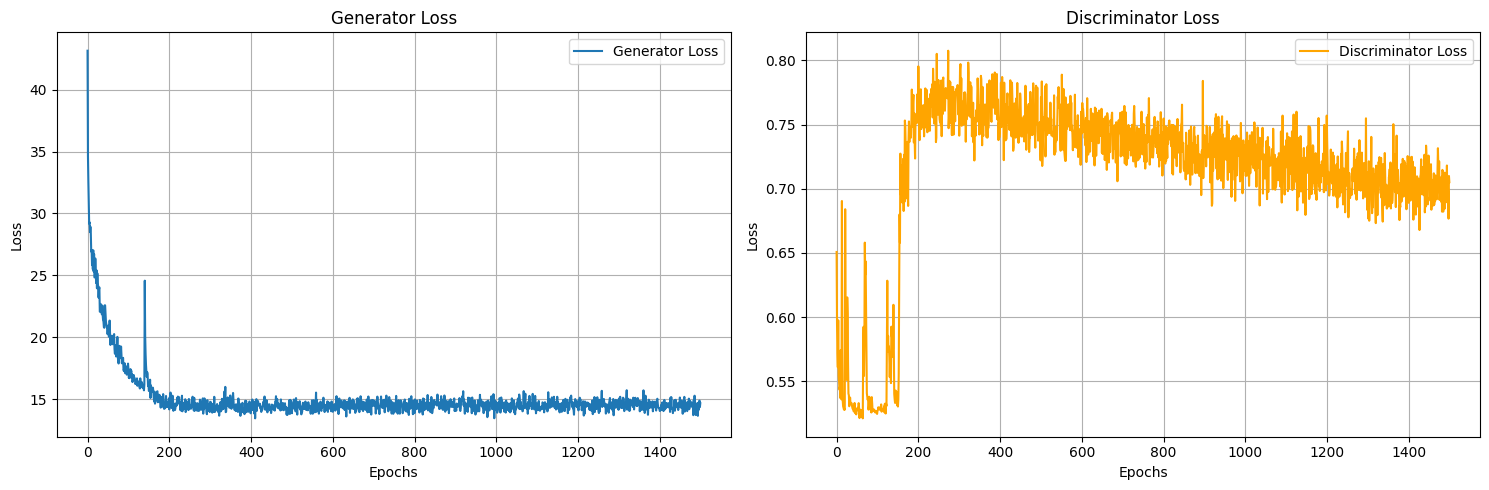

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from utils.lossTracker import *

data  = load_losses()
train_loss = data['g_loss']
val_loss = data['d_loss']

# Построение графиков с использованием subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# График для Train Loss
axes[0].plot(train_loss, label='Generator Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Generator Loss')
axes[0].legend()
axes[0].grid(True)

# График для Validation Loss
axes[1].plot(val_loss, label='Discriminator Loss', color='orange')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].set_title('Discriminator Loss')
axes[1].legend()
axes[1].grid(True)

# Отображение графиков
plt.tight_layout()
plt.show()


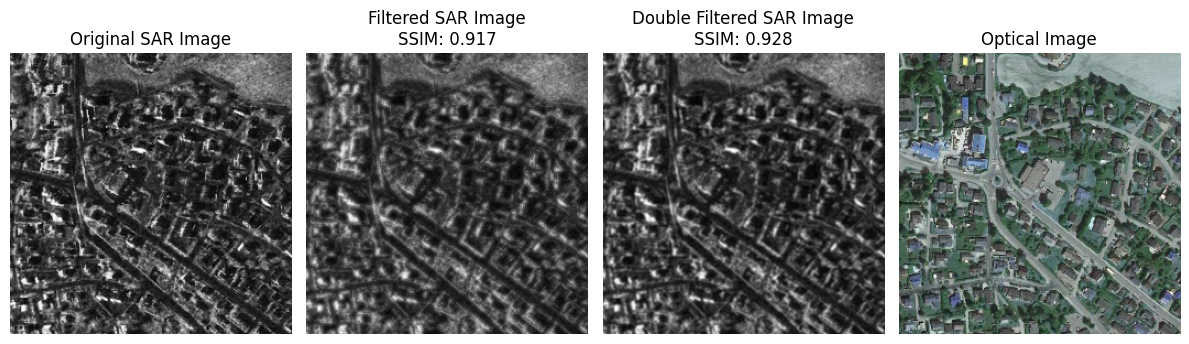

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import generic_filter
from skimage.metrics import structural_similarity as ssim

def frost_filter(image, damping_factor=2.0, window_size=5):
    """
    Применяет фильтр Фроста для снижения спекл-шума в изображении.
    
    :param image: Входное изображение в виде numpy массива.
    :param damping_factor: Коэффициент затухания, регулирующий степень фильтрации.
    :param window_size: Размер окна фильтрации (должен быть нечетным).
    :return: Отфильтрованное изображение.
    """
    def frost_function(values):
        center_pixel = values[len(values) // 2]
        local_mean = np.mean(values)
        local_variance = np.var(values)
        if local_variance == 0:
            return center_pixel
        coefficient_of_variation = np.sqrt(local_variance) / local_mean
        weight = np.exp(-damping_factor * coefficient_of_variation)
        return weight * center_pixel + (1 - weight) * local_mean

    # Применяем фильтр к изображению
    filtered_image = generic_filter(image, frost_function, size=window_size)
    return filtered_image

import numpy as np
from scipy.ndimage import generic_filter

def double_adaptive_frost_filter(image, damping_factor=2, window_size=5, k_factor=1):
    """
    Реализация Double-Adaptive Frost Filter.
    :param image: Входное изображение (numpy array).
    :param damping_factor: Коэффициент затухания фильтра Фроста.
    :param window_size: Размер окна фильтрации.
    :param k_factor: Коэффициент для адаптации радиометрических характеристик.
    :return: Отфильтрованное изображение.
    """
    def frost_function(values):
        center_pixel = values[values.size // 2]
        local_mean = np.mean(values)
        local_std = np.std(values)
        
        if local_std == 0:  # Избегаем деления на 0
            return center_pixel

        # Пространственная адаптация
        weight_spatial = np.exp(-damping_factor * (local_std / local_mean))

        # Радиометрическая адаптация
        weight_radiometric = np.exp(-k_factor * abs(center_pixel - local_mean) / local_mean)
        
        # Итоговый вес
        weight = weight_spatial * weight_radiometric

        # Возвращаем отфильтрованный пиксель
        return center_pixel * weight + local_mean * (1 - weight)
    
    # Применяем Double-Adaptive Frost Filter с generic_filter
    filtered_image = generic_filter(image, frost_function, size=window_size)
    return filtered_image

# Load SAR image
image_path = "dataset/testA/6_2640_0.jpg"
sar_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
optical_image = cv2.imread('dataset/testB/6_2640_0.jpg')
optical_image = cv2.cvtColor(optical_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for proper display

sar_image = cv2.resize(sar_image, (256, 256))
optical_image = cv2.resize(optical_image, (256, 256))

# Apply Frost filter
filtered_image = frost_filter(sar_image)
double_filtered_image = double_adaptive_frost_filter(np.array(sar_image, dtype=np.uint8), damping_factor=2, window_size=3, k_factor=2)


# Calculate SSIM
ssim_score = ssim(sar_image, filtered_image)

# Create figure with two subplots side by side
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 5))

# Display original SAR image
ax1.imshow(sar_image, cmap='gray')
ax1.set_title('Original SAR Image')
ax1.axis('off')

# Display filtered image
ax2.imshow(filtered_image, cmap='gray')
ax2.set_title(f'Filtered SAR Image\nSSIM: {ssim_score:.3f}')
ax2.axis('off')

ax3.imshow(double_filtered_image, cmap='gray')
ax3.set_title(f'Double Filtered SAR Image\nSSIM: {ssim(sar_image, double_filtered_image):.3f}')
ax3.axis('off')

# Display optical image
ax4.imshow(optical_image)
ax4.set_title(f'Optical Image')
ax4.axis('off')

plt.tight_layout()
plt.show()


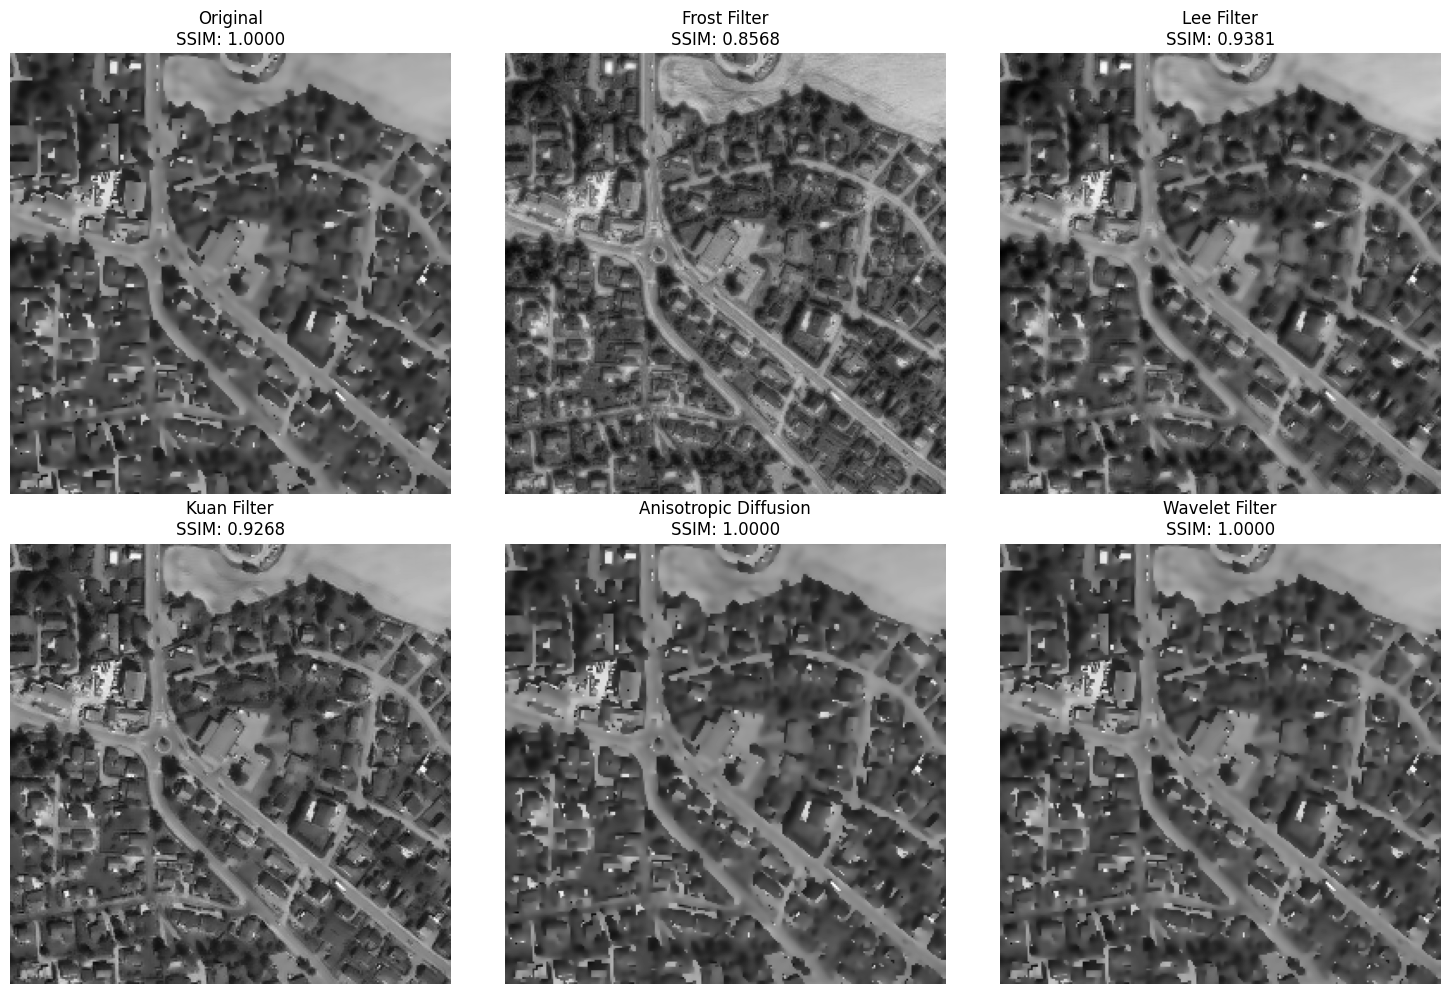

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from scipy.ndimage import uniform_filter, generic_filter
from skimage.restoration import denoise_wavelet

# Загрузка и предварительная обработка изображения
image_path = 'dataset/testB/6_2640_0.jpg'
original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
resized_image = cv2.resize(original_image, (256, 256))

# Преобразование изображения к типу float64 для предотвращения ошибок при арифметических операциях
resized_image = resized_image.astype(np.float64)

# Функции фильтров
def apply_frost_filter(image, damping_factor=2.0, window_size=5):
    def frost_function(values):
        center_pixel = values[len(values) // 2]
        local_mean = np.mean(values)
        local_variance = np.var(values)
        if local_variance == 0:
            return center_pixel
        coefficient_of_variation = np.sqrt(local_variance) / local_mean
        weight = np.exp(-damping_factor * coefficient_of_variation)
        return weight * center_pixel + (1 - weight) * local_mean
    return generic_filter(image, frost_function, size=window_size)

def apply_lee_filter(image, window_size=5):
    mean = uniform_filter(image, window_size)
    mean_sq = uniform_filter(image**2, window_size)
    variance = mean_sq - mean**2
    overall_variance = np.var(image)
    weight = variance / (variance + overall_variance)
    return mean + weight * (image - mean)

def apply_kuan_filter(image, window_size=5):
    mean = uniform_filter(image, window_size)
    mean_sq = uniform_filter(image**2, window_size)
    variance = mean_sq - mean**2
    overall_variance = np.var(image)
    cu = 0.25  # коэффициент вариации шума
    weight = variance / (variance + cu * overall_variance)
    return mean + weight * (image - mean)

def apply_anisotropic_diffusion(image, num_iter=15, kappa=30, gamma=0.1):
    for _ in range(num_iter):
        nabla_north = np.roll(image, -1, axis=0) - image
        nabla_south = np.roll(image, 1, axis=0) - image
        nabla_east = np.roll(image, -1, axis=1) - image
        nabla_west = np.roll(image, 1, axis=1) - image
        c_north = np.exp(-(nabla_north / kappa)**2)
        c_south = np.exp(-(nabla_south / kappa)**2)
        c_east = np.exp(-(nabla_east / kappa)**2)
        c_west = np.exp(-(nabla_west / kappa)**2)
        image += gamma * (
            c_north * nabla_north + c_south * nabla_south +
            c_east * nabla_east + c_west * nabla_west
        )
    return image

def apply_wavelet_filter(image):
    return denoise_wavelet(image, channel_axis=None, rescale_sigma=True)

# Применение фильтров
filters = {
    'Original': resized_image,
    'Frost Filter': apply_frost_filter(resized_image),
    'Lee Filter': apply_lee_filter(resized_image),
    'Kuan Filter': apply_kuan_filter(resized_image),
    'Anisotropic Diffusion': apply_anisotropic_diffusion(resized_image),
    'Wavelet Filter': apply_wavelet_filter(resized_image)
}

# Вычисление SSIM и отображение результатов
plt.figure(figsize=(15, 10))
for i, (name, img) in enumerate(filters.items()):
    if name == 'Original':
        ssim_index = 1.0  # SSIM оригинального изображения с самим собой
    else:
        ssim_index = ssim(resized_image, img, data_range=img.max() - img.min())
    plt.subplot(2, 3, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f'{name}\nSSIM: {ssim_index:.4f}')
    plt.axis('off')
plt.tight_layout()
plt.show()


In [6]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms.functional import to_tensor, to_pil_image
import torch.nn.functional as F
from PIL import Image, ImageFilter
import cv2
import numpy as np
from scipy.ndimage import median_filter

# Настройки
IMAGE_SIZE = 256  # Размер для ресайза изображений
DATA_DIR = "./dataset"  # Путь к папке с данными
BATCH_SIZE = 16  # Размер батча

# Аугментации
augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Случайное отражение по горизонтали
    transforms.RandomVerticalFlip(p=0.5),  # Случайное отражение по вертикали
    transforms.RandomRotation(degrees=15),  # Случайное вращение на ±15 градусов
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)  # Случайные изменения яркости, контраста, насыщенности и оттенка
])

# Трансформации
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),  # Преобразование [0, 255] -> [0, 1]
    transforms.Normalize(mean=(0.5,), std=(0.5,))  # Преобразование [0, 1] -> [-1, 1]
])

# Функция для применения медианного фильтра и Лапласа
def preprocess_with_laplace(image):
    # Применяем медианный фильтр
    image = image.filter(ImageFilter.MedianFilter(size=5))

    # Конвертируем в numpy для фильтра Лапласа
    img_np = np.array(image, dtype=np.uint8)

    # Фильтр Лапласа
    laplace_filtered = cv2.Laplacian(img_np, cv2.CV_64F)
    laplace_filtered = np.uint8(np.absolute(laplace_filtered))  # Абсолютные значения

    return img_np, laplace_filtered  # Возвращаем исходное и фильтрованное изображение


# Датасет
class SARToOpticalDataset(Dataset):
    def __init__(self, sar_dir, optical_dir, transform=None, augment=None):
        self.sar_dir = sar_dir
        self.optical_dir = optical_dir
        self.transform = transform
        self.augment = augment
        self.sar_images = os.listdir(sar_dir)
        self.optical_images = os.listdir(optical_dir)

    def __len__(self):
        return len(self.sar_images)

    def __getitem__(self, idx):
        # Загружаем SAR-изображение
        sar_path = os.path.join(self.sar_dir, self.sar_images[idx])
        sar_image = Image.open(sar_path).convert("L")  # Ч/б изображение

        # Получаем исходное и Laplace-фильтрованное изображение
        sar_np, laplace_filtered = preprocess_with_laplace(sar_image)

        # Объединяем SAR и Laplace по каналу
        combined_sar = np.stack([sar_np, laplace_filtered], axis=-1)  # (H, W, 2)
        combined_sar = to_pil_image(combined_sar)  # Конвертируем в PIL

        # Загружаем оптическое изображение
        optical_path = os.path.join(self.optical_dir, self.optical_images[idx])
        optical_image = Image.open(optical_path).convert("RGB")  # Цветное изображение

        # Применяем аугментации (если есть)
        if self.augment:
            augmented = self.augment(transforms.ToTensor()(combined_sar))
            combined_sar = to_pil_image(augmented)
            optical_image = self.augment(optical_image)

        if self.transform:
            combined_sar = self.transform(combined_sar)
            optical_image = self.transform(optical_image)

        return combined_sar, optical_image

# Создаём экземпляры датасетов
train_dataset = SARToOpticalDataset(
    sar_dir=os.path.join(DATA_DIR, "trainA"),
    optical_dir=os.path.join(DATA_DIR, "trainB"),
    transform=transform,
    augment=augmentation
)

test_dataset = SARToOpticalDataset(
    sar_dir=os.path.join(DATA_DIR, "testA"),
    optical_dir=os.path.join(DATA_DIR, "testB"),
    transform=transform
)

# DataLoader для батчей
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# Проверка работы
if __name__ == "__main__":
    for sar, optical in train_loader:
        print(f"SAR batch shape: {sar.shape}")
        print(f"Optical batch shape: {optical.shape}")
        break


RuntimeError: DataLoader worker (pid(s) 11628, 20156, 19724, 14016) exited unexpectedly